### Read the results from the inspiral HOM output file

In [1]:
from __future__ import division

import numpy as np
import h5py


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

import utils
uts = utils.MiscellaneousUtils()

In [2]:
f = h5py.File("GW190814bv_L1_C01_fISCO_0p45.h5", 'r') 

In [3]:
f.keys()

[u'CWT', u'analysis', u'inputparams', u'noisebg']

'CWT': contains the data related to the to the time-frequency map and tf map of the on-source data

In [4]:
f['analysis'].keys()

[u'LLR22',
 u'LLR22_33',
 u'LLR22_33_44',
 u'Salpha22',
 u'Salpha33',
 u'Salpha44',
 u'Yalpha',
 u'alpha_arr',
 u'beta33',
 u'beta33H0',
 u'beta44',
 u'beta44H0',
 u'freqs',
 u'mualpha',
 u'psd',
 u'pvalue33',
 u'pvalue44']

### Time-frequency map of the on-source data $t = [t_c -4, t_c+1]$

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(  np.abs(f['CWT']['cwt'][:])**2.0 , extent=[-4.0, 1.0, \
        min(f['CWT']['freqs'][:]), max(f['CWT']['freqs'][:])],\
           aspect='auto', origin='lower')

#ax.plot(t2-4.0, 1.5*f2, lw=0.5, dashes=(5, 10), color='w', label=r'$m=3$ track')
#ax.set_title("Spectrogram of on-source data", fontsize=17)
ax.set_ylim(1.0, 200)
ax.set_ylabel(r'Frequency $(\mathrm{Hz})$', fontsize=15)
ax.set_xlabel(r'Time $(\mathrm{s})$', fontsize=15)
fig.colorbar(im)
ax.set_xlim(-2.5, 0.2)
#ax.legend(loc=2, facecolor='green')
fig.tight_layout()
plt.savefig('tfmap_S190814bv_C01.png', dpi=200)

### Plot of $Y(\alpha)$ from on-source data

In [6]:
plt.plot( f['analysis']['alpha_arr'][:], f['analysis']['Yalpha'][:] )
plt.xlabel( r"$\alpha$", fontsize=16 )
plt.ylabel( r"$Y(\alpha)$", fontsize=16 )
plt.grid(True)

### Statistic value for the evidence of m=3 mode

In [16]:
print "beta33 = ", f['analysis']['beta33'][()]
print "p-value = ", f['analysis']['pvalue33'][()]

print "beta44 = ", f['analysis']['beta44'][()]
print "p-value = ", f['analysis']['pvalue44'][()]

beta33 =  10.218378944382557
p-value =  2.932319365733787e-14
beta44 =  1.0993984201377387
p-value =  0.20401144610929398


### Background distribution for m=3 mode obtained from off-source data

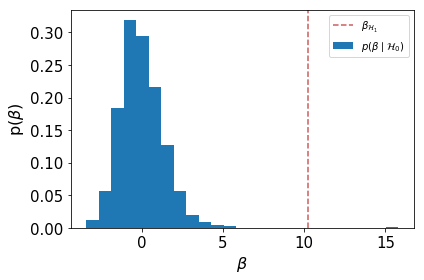

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.hist(f['analysis']['beta33H0'][:], density=True, bins=25, \
            label=r"$p( \beta \mid \mathcal{H}_0 )$")
ax.axvline( x=f['analysis']['beta33'][()], linestyle='--', color='indianred', label=r'$\beta_{\mathcal{H}_1 }$' )
ax.set_xlabel(r'$\beta $', fontsize=16)
ax.set_ylabel(r'p($\beta) $', fontsize=16)
ax.legend()
plt.tight_layout()

### Load the entire data

In [9]:
alpha_arr = f['analysis']['alpha_arr'][:]
Salpha22 = f['analysis']['Salpha22'][:]
Salpha33 = f['analysis']['Salpha33'][:]
Salpha44 = f['analysis']['Salpha44'][:]
Yalpha = f['analysis']['Yalpha']
mualpha = f['analysis']['mualpha']

keys = f['noisebg'].keys()
Nalpha_dataFull = f['noisebg']['nalphas'][:][:,1:,]

idxx = np.unique(np.hstack(( np.where( np.max(Nalpha_dataFull, axis=1) >100000 )[0], \
                                np.where( Nalpha_dataFull[:,0] >2500 )[0] )))

Nalpha_dataFull = np.delete(Nalpha_dataFull, idxx, axis=0)
times = np.delete(f['noisebg']['nalphas'][:][:,0], idxx, axis=0) 

midIdx = np.where(times > f['inputparams']['l1_end_time'][()] )[0][0]
deltaIdx = 1200
Nalpha_data = Nalpha_dataFull.copy()[midIdx-deltaIdx:midIdx+deltaIdx]

# Mean at each \alpha
mualpha = np.mean(Nalpha_dataFull, axis=0)
xy = np.vstack([Nalpha_data[:,j] - mualpha[j] for j in range(len(mualpha))])

# Covariance matrix
npcov = np.cov(xy)
# Inverse of covariance matrix
covinv = np.linalg.inv(npcov)


### Produce the final plot

In [14]:

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(alpha_arr, Yalpha, lw=1.5, c='k', label=r'on-source: $Y(\alpha)$ ')
ax.axvline(x=1.5, ls='--', c='indianred', lw=1.2)

ax.set_xlabel(r"$\alpha$", fontsize=18)
ax.set_ylabel(r"$Y(\alpha)$", fontsize=18)
#ax.set_title("GW190412: Asymmetric BBH event", fontsize=17)
ax.grid(linestyle='dashed')

ax.plot(alpha_arr, mualpha, color='b', lw=0.8, ls='--', label=r'off source: $\mu(\alpha)$')
ax.fill_between(alpha_arr, mualpha, mualpha+np.diagonal(npcov)**0.5, color='gray', edgecolor="b", linewidth=0.0, \
                alpha=0.5, label=r'off-source: $\pm \sigma$')
ax.fill_between(alpha_arr, mualpha, mualpha-np.diagonal(npcov)**0.5, \
                edgecolor="b", linewidth=0.0, color='gray', alpha=0.5)
ax.set_xlim(0.2, 2.9)
ax.minorticks_on()

ax.tick_params(axis='both',which='minor',length=2,width=1, direction='in')
ax.tick_params(axis='both',which='major',length=6,width=1.5, direction='in')


sub_axes = plt.axes([.67, .37, .3, .25]) 
# plot the zoomed portion
sub_axes.plot(alpha_arr, Yalpha, lw=1., c = 'k') 
sub_axes.set_ylim(500, 6000)
sub_axes.set_xlim(0.5, 2.5)
sub_axes.ticklabel_format( axis='y', scilimits=(0,0), labelsize=12)

sub_axes.tick_params(axis='both',which='minor',length=2,width=1, direction='in', labelsize=12)
sub_axes.tick_params(axis='both',which='major',length=5,width=1.3, direction='in', labelsize=12)
sub_axes.set_xticks([0.5, 1.0, 1.5, 2.0])


sub_axes.plot(alpha_arr, mualpha, color='gray', lw=0.7, ls=':', label=r'off source: $\mu(\alpha)$')
sub_axes.fill_between(alpha_arr, mualpha, mualpha+np.diagonal(npcov)**0.5, color='gray', alpha=0.5, \
                edgecolor="b", linewidth=0.0, label=r'off-source: $\pm \sigma$')
sub_axes.fill_between(alpha_arr, mualpha, mualpha-np.diagonal(npcov)**0.5, color='gray', \
                      edgecolor="b", linewidth=0.0, alpha=0.5)



#plt.tick_params(axis='both', which='minor', labelsize=12)



sub_axes.minorticks_on()
sub_axes.grid(linestyle='dashed')
sub_axes.grid(b=True, which='minor', color='gray', linestyle='--', lw=0.2)

ax.ticklabel_format( axis='y', scilimits=(0,0))

ax.legend(loc=1)
plt.tight_layout()
plt.savefig("Yalpha_S190814bv_C01.png", dpi=300)